<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">1. Import Librairies</span>

<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">   Connect to API EndPoint</span>

<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">   Create the Workspace</span>

In [1]:
from ctm_python_client.core.workflow import *
from ctm_python_client.core.comm import *
from ctm_python_client.core.credential import *
from aapi import *
from ctm_python_client.ext.viz import get_graph
import os
BASE_PATH = os.path.abspath("")
with open(BASE_PATH + "/secrets", "r") as fp:
    ctm_key = fp.readline().strip()

URL='https://.controlm.com/automation-api'

my_environment = Environment.create_saas(URL,
                                         api_key=ctm_key)
MyCTM = "IN01"
workflow = Workflow(my_environment,
                    WorkflowDefaults(controlm_server=MyCTM,
                                     application='MPE',
                                     sub_application='Module4')
                    )


<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">2. Create the Folder and jobs</span>

In [4]:

Myfolder = "mpe-data-pipeline"
MySITE = "mpe_site1"
# Folder
folder = Folder(Myfolder,
                site_standard=MySITE,
                description='Control-M Data Pipeline',
                order_method=Folder.OrderMethod.Manual,
                variables=[
                     {'EXTRACT_CSV': '/tmp/snowflake_query.csv'},
                     {'MYFILE': 'demo123.txt'}
                     ])
workflow.add(folder)


#  Jobs
myJobOS1 = JobCommand("OS-linux1", 
               command='df -h', 
               run_as='bmc',
               host='zzz-linux-agents'
               )

myJobOS2 = JobCommand("OS-linux2", 
               command='sleep 5', 
               run_as='bmc',
               host='zzz-linux-agents'
               )

myJobDB1 = JobDatabaseEmbeddedQuery("Postgres-data", 
                             query='select title,release_year from film',
                             connection_profile='MPE_PGSQL', 
                             host='zzz-eks-sandbox-1.bmci2t.com',
                             output_execution_log='N', output_sql_output='Y', sql_output_format='CSV', run_as='MPE_PGSQL',
                             output=Job.Output(
                                 operation=Job.Output.Operation.Copy, destination='%%EXTRACT_CSV')
                             )

myJobAZ1 = JobFileTransfer("Transfer-to-Azure-Blob",
                    host='zzz-eks-sandbox-1.bmci2t.com',
                    connection_profile_src='ZZZ_MFT_FS_1', 
                    connection_profile_dest='ZZZ_MFT_BLOB',
                    azure_container_name_dest='incoming',
                    number_of_retries='5', 
                    file_transfers=[
                        FileTransfer(src='%%EXTRACT_CSV', dest='/',
                                     transfer_type=FileTransfer.TransferType.Binary,
                                     transfer_option=FileTransfer.TransferOption.SrcToDest),
                   ]
                )


myJobADF = JobAzureDataFactory("Azure Data Factory-Job",
                   connection_profile='ZZZ_AZE_DAFA',
                   resource_group_name='mpe-res1',
                   data_factory_name='mpe-datafactory',
                   host='zzz-eks-sandbox-1.bmci2t.com',
                   pipeline_name='PipelineCRM',
                   parameters='{}',
                   status_polling_frequency='20'
                   )



myJobBlobS3 = JobFileTransfer("Azure-Blob-to-AWS-S3",
                    connection_profile_src='ZZZ_MFT_BLOB', 
                    connection_profile_dest='ZZZ_MFT_S3',
                    azure_container_name_src='outgoing',
                    s3_bucket_name_dest='zzz-file-upload-s3',
                    number_of_retries='5', 
                    host='zzz-linux-agents',
                    file_transfers=[
                        FileTransfer(src='/snowflake_query.csv', dest='/',
                                     transfer_type=FileTransfer.TransferType.Binary,
                                     transfer_option=FileTransfer.TransferOption.SrcToDest),
                    ]
                    )

myJobAWS = JobAWSLambda("AWS-lambda",
                   connection_profile='ZZZ_AWS',
                   function_name='mpe-test1',
                   version='$LATEST',
                   host='zzz-linux-agents',
                   payload='{"Number1": 974,"Number2": 78,"filedemo":"%%MYFILE"}',
                   append_log=True
                   )

jobSLA = JobSLAManagement(Myfolder + "-SLA",
                     service_name='mpe-demo-python',
                     run_as='ctmagent',
                     service_priority='1',
                     host='zzz-linux-agents',
                     job_runs_deviations_tolerance='1',
                     complete_in=JobSLAManagement.CompleteIn(time='00:10'),
                     average_run_time_tolerance=JobSLAManagement.AverageRunTimeTolerance(
                         average_run_time='10',
                         units=JobSLAManagement.AverageRunTimeTolerance.Units.Minutes
                     )
                     )



<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">3. Dependencies and check the Workflow: Build/Validate and Display</span>

The workflow is valid!


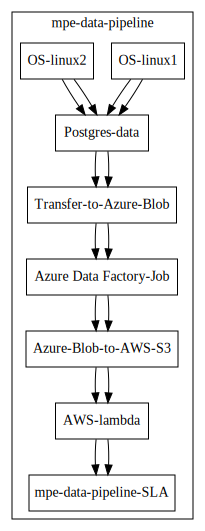

In [5]:
# Dependencies
workflow.chain(
    [myJobOS1, myJobDB1,myJobAZ1,myJobADF,myJobBlobS3,myJobAWS,jobSLA],inpath=Myfolder
)
workflow.chain(
    [myJobOS2,myJobDB1],inpath=Myfolder
)

if workflow.build().is_ok():
    print('The workflow is valid!')

else:
    print('The workflow is NOT valid!')
    print(workflow.build().errors)

#workflow.dumps_json(indent=4)
get_graph(workflow)
#graph = get_graph(workflow)
#graph.render("test_graph", format='png')



<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">4. Deploy to Check-in</span>

In [6]:
if workflow.deploy().is_ok():
    print('The workflow was deployed to Control-M!')
else:
    print('The workflow is NOT deployed!')
    print(workflow.deploy().errors)


The workflow was deployed to Control-M!


<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">5. Run</span>

In [7]:
print('Run')
run = workflow.run()
run.print_statuses()

Run
Run Status
--------------------------------------------------
    mpe-data-pipeline  .................  Executing
    OS-linux1  .........................  Ended OK
    Postgres-data  .....................  Wait Condition
    Transfer-to-Azure-Blob  ............  Wait Condition
    Azure Data Factory-Job  ............  Wait Condition
    Azure-Blob-to-AWS-S3  ..............  Wait Condition
    AWS-lambda  ........................  Wait Condition
    mpe-data-pipeline-SLA  .............  Wait Condition
    OS-linux2  .........................  Executing



<span style="color:green;font-weight: 400; font-size: 16px; font-style: normal">6. Monitor, Display output, Rerun, Set to OK ...</span>

In [11]:
run.print_statuses()
run.print_output('mpe-data-pipeline/Transfer-to-Azure-Blob')



Run Status
--------------------------------------------------
    mpe-data-pipeline  .................  Executing
    OS-linux1  .........................  Ended OK
    Postgres-data  .....................  Ended OK
    Transfer-to-Azure-Blob  ............  Ended Not OK
    Azure Data Factory-Job  ............  Wait Condition
    Azure-Blob-to-AWS-S3  ..............  Wait Condition
    AWS-lambda  ........................  Wait Condition
    mpe-data-pipeline-SLA  .............  Wait Condition
    OS-linux2  .........................  Ended OK

+ Job started at '0229 08:30:36:524' orderno - '06qol' runno - '00001' Number of transfers - 1, Job name - 'Transfer-to-Azure-Blob'
+ Host1 'zzz-eks-sandbox-1.bmci2t.com' [Unix-SFTP] username 'bmc' - Host2 ['AZURE' - Connection Profile: 'ZZZ_MFT_BLOB', Container:\
 'incoming']
Local host is zzz-eks-sandbox-1.bmci2t.com
Connection Profile 'ZZZ_MFT_FS_1' is stored in EM database.
Connection Profile 'ZZZ_MFT_BLOB' is stored in EM database.
+*******